In [15]:
import os
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from collections import Counter

In [16]:
DATASET_DIR = r"E:\DatasetRecon\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset"            # carpeta original con subcarpetas por clase
OUTPUT_DIR = "dataset_preprocessed"  # carpeta destino para los resultados
IMG_SIZE = 224                                # tamaño final (H,W)
RANDOM_STATE = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)
CATEGORIES = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
print("Categorías:", CATEGORIES)

Categorías: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


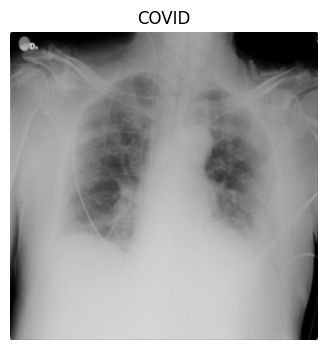

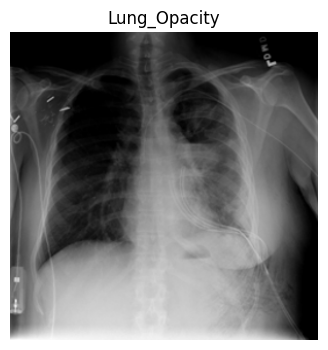

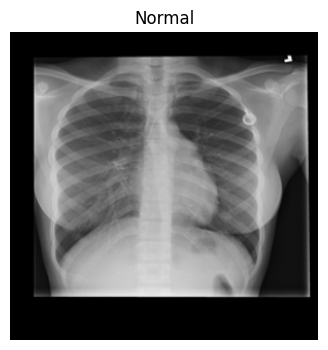

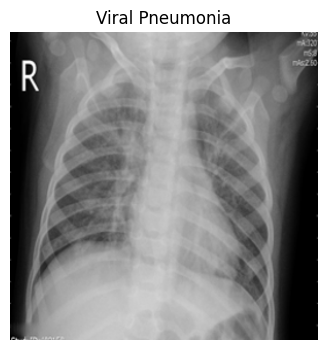

In [17]:
def show_samples_per_class(dataset_dir, categories, n=1):
    for c in categories:
        folder = os.path.join(dataset_dir, c)
        files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]
        if not files:
            continue
        for i in range(min(n, len(files))):
            img = cv2.imread(os.path.join(folder, files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4,4)); plt.imshow(img); plt.title(c); plt.axis('off'); plt.show()

show_samples_per_class(DATASET_DIR, CATEGORIES, n=1)

In [18]:
def resize_image(img, size=IMG_SIZE):
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

def crop_remove_borders(img, border_px=20):
    h, w = img.shape[:2]
    return img[border_px:h-border_px, border_px:w-border_px]

def apply_clahe_rgb(img):
    # convertir a LAB y aplicar CLAHE en L
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def apply_bilateral(img, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(img, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)

def normalize_to_uint8(img):
    # img float o uint8 -> aseguramos uint8 en 0..255
    if img.dtype == np.float32 or img.dtype == np.float64:
        img_scaled = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    else:
        img_scaled = img
    return img_scaled



In [25]:
def pipeline_no_filter(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    # 1) recorte automático ROI
    #img = crop_by_largest_contour(img)
    # 2) eliminar bordes pequeños
    img = crop_remove_borders(img, border_px=8)
    # 3) aplicar CLAHE
    img = apply_clahe_rgb(img)
    # 4) redimensionar
    img = resize_image(img, IMG_SIZE)
    # 5) normalizar float32 [0,1] para further processing (no guardado)
    img_f = img.astype(np.float32) / 255.0
    return img_f

In [32]:
def pipeline_with_bilateral(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    #img = crop_by_largest_contour(img)
    img = crop_remove_borders(img, border_px=8)
    img = apply_clahe_rgb(img)
    # aplicar bilateral ANTES de resize (más consistente)
    img = apply_bilateral(img, d=9, sigmaColor=75, sigmaSpace=75)
    img = resize_image(img, IMG_SIZE)
    img_f = img.astype(np.float32) / 255.0
    return img_f

In [28]:
OUT_RAW = os.path.join(OUTPUT_DIR, "raw_preproc")
OUT_FILTERED = os.path.join(OUTPUT_DIR, "filtered_preproc")
os.makedirs(OUT_RAW, exist_ok=True)
os.makedirs(OUT_FILTERED, exist_ok=True)
for c in CATEGORIES:
    os.makedirs(os.path.join(OUT_RAW, c), exist_ok=True)
    os.makedirs(os.path.join(OUT_FILTERED, c), exist_ok=True)

# Procesamiento (puede tardar, se hace una sola vez)
for c in CATEGORIES:
    input_folder = os.path.join(DATASET_DIR, c)
    for fname in tqdm(os.listdir(input_folder), desc=f"Procesando {c}"):
        src = os.path.join(input_folder, fname)
        try:
            img_raw = pipeline_no_filter(src)
            if img_raw is None: 
                continue
            # guardar como uint8
            out_path_raw = os.path.join(OUT_RAW, c, fname)
            cv2.imwrite(out_path_raw, cv2.cvtColor(normalize_to_uint8(img_raw), cv2.COLOR_RGB2BGR))
            
            img_filt = pipeline_with_bilateral(src)
            out_path_filt = os.path.join(OUT_FILTERED, c, fname)
            cv2.imwrite(out_path_filt, cv2.cvtColor(normalize_to_uint8(img_filt), cv2.COLOR_RGB2BGR))
        except Exception as e:
            # log opcional: print("Error en", src, e)
            continue

print("Procesamiento finalizado. Carpetas:", OUT_RAW, OUT_FILTERED)

Procesando Viral Pneumonia: 100%|██████████| 1345/1345 [00:07<00:00, 170.51it/s]

Procesamiento finalizado. Carpetas: dataset_preprocessed\raw_preproc dataset_preprocessed\filtered_preproc


In [33]:
OUT_RAW = os.path.join(OUTPUT_DIR, "raw_preproc")
OUT_FILTERED = os.path.join(OUTPUT_DIR, "filtered_preproc")
os.makedirs(OUT_RAW, exist_ok=True)
os.makedirs(OUT_FILTERED, exist_ok=True)
for c in CATEGORIES:
    os.makedirs(os.path.join(OUT_RAW, c), exist_ok=True)
    os.makedirs(os.path.join(OUT_FILTERED, c), exist_ok=True)

# Procesamiento (puede tardar, se hace una sola vez)
for c in CATEGORIES:
    input_folder = os.path.join(DATASET_DIR, c)
    for fname in tqdm(os.listdir(input_folder), desc=f"Procesando {c}"):
        src = os.path.join(input_folder, fname)
        try:
            img_filt = pipeline_with_bilateral(src)
            out_path_filt = os.path.join(OUT_FILTERED, c, fname)
            cv2.imwrite(out_path_filt, cv2.cvtColor(normalize_to_uint8(img_filt), cv2.COLOR_RGB2BGR))
        except Exception as e:
            # log opcional: print("Error en", src, e)
            continue

print("Procesamiento finalizado. Carpetas:", OUT_RAW, OUT_FILTERED)

Procesando Viral Pneumonia: 100%|██████████| 1345/1345 [00:15<00:00, 84.70it/s] 

Procesamiento finalizado. Carpetas: dataset_preprocessed\raw_preproc dataset_preprocessed\filtered_preproc
